In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
from itertools import combinations
from collections import defaultdict
import sys
import os
import scipy.stats

# Add packages to path
sys.path.append('/Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/packages')
sys.path.append('/Users/shihcheng/Documents/Work/Python/uwb-localization-mesh')

from packages.datatypes.datatypes import AnchorConfig
from packages.localization_algos.edge_creation.transforms import create_relative_measurement
from packages.localization_algos.edge_creation.anchor_edges import create_anchor_anchor_edges
from packages.localization_algos.pgo.solver import PGOSolver

# Default anchor positions (from datatypes README)
DEFAULT_ANCHOR_POSITIONS = {
    0: np.array([480, 600, 0]),  # top-right
    1: np.array([0, 600, 0]),    # top-left  
    2: np.array([480, 0, 0]),    # bottom-right
    3: np.array([0, 0, 0])       # bottom-left
}

In [2]:
def load_data(csv_path: str) -> List[Dict]:
    """Load and parse the CSV data."""
    data = []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                # Parse the filtered_binned_data_json
                filtered_data = json.loads(row['filtered_binned_data_json'])
                row['filtered_data'] = filtered_data
                
                # Parse the raw_binned_data_json
                raw_data = json.loads(row['raw_binned_data_json'])
                row['raw_data'] = raw_data

                # Parse numeric fields
                row['ground_truth_x'] = float(row['ground_truth_x'])
                row['ground_truth_y'] = float(row['ground_truth_y'])
                row['ground_truth_z'] = float(row['ground_truth_z'])
                row['pgo_x'] = float(row['pgo_x'])
                row['pgo_y'] = float(row['pgo_y'])
                row['pgo_z'] = float(row['pgo_z'])
                
                data.append(row)
            except (json.JSONDecodeError, KeyError, ValueError) as e:
                print(f"Warning: Skipping row due to parsing error: {e}")
                continue
    return data

In [3]:

def mask_measurements(measurements: Dict[str, List[List[float]]], 
                     selected_anchors: List[int]) -> Dict[str, List[List[float]]]:
    """Mask measurements to only include selected anchors."""
    masked = {}
    for anchor_id in selected_anchors:
        anchor_key = str(anchor_id)
        if anchor_key in measurements:
            masked[anchor_key] = measurements[anchor_key]
    return masked

In [4]:

def transform_measurements_to_global(measurements: Dict[str, List[List[float]]], 
                                   phone_node_id: int = 0) -> List[Tuple[str, str, np.ndarray]]:
    """Transform local measurements to global coordinates and create edges."""
    edges = []
    
    for anchor_id_str, vectors in measurements.items():
        anchor_id = int(anchor_id_str)
        for vector in vectors:
            # Convert to numpy array and transform to global coordinates
            local_vector = np.array(vector)
            try:
                from_node, to_node, global_vector = create_relative_measurement(
                    anchor_id, phone_node_id, local_vector
                )
                edges.append((from_node, to_node, global_vector))
            except ValueError as e:
                # Skip invalid measurements
                continue
    
    return edges

In [5]:
def run_pgo_with_masked_measurements(measurements: Dict[str, List[List[float]]], 
                                   selected_anchors: List[int]) -> Optional[np.ndarray]:
    """Run PGO with measurements masked to selected anchors."""
    
    # Mask measurements to only include selected anchors
    masked_measurements = mask_measurements(measurements, selected_anchors)
    
    if not masked_measurements:
        return None
    
    # Transform measurements to global coordinates
    edges = transform_measurements_to_global(masked_measurements)
    
    if not edges:
        return None
    
    # Create anchor config for ALL anchors (positions always available)
    anchor_config = AnchorConfig(positions=DEFAULT_ANCHOR_POSITIONS)
    
    # Add anchor-anchor edges for ALL anchors
    anchor_edges = create_anchor_anchor_edges(anchor_config)
    all_edges = edges + anchor_edges
    
    # Set up nodes (ALL anchors are fixed, phone is unknown)
    nodes = {}
    for anchor_id in DEFAULT_ANCHOR_POSITIONS.keys():
        nodes[f'anchor_{anchor_id}'] = DEFAULT_ANCHOR_POSITIONS[anchor_id]
    nodes['phone_0'] = None  # Unknown position
    
    # Run PGO
    solver = PGOSolver()
    try:
        result = solver.solve(nodes, all_edges, DEFAULT_ANCHOR_POSITIONS)
        if result.success and 'phone_0' in result.node_positions:
            return result.node_positions['phone_0'][:2]  # Return only x, y (ignore z)
    except Exception as e:
        # PGO failed
        pass
    
    return None

In [6]:

def estimate_positions_single_anchor(measurements: Dict[str, List[List[float]]], 
                                   anchor_id: int,
                                   ground_truth: Tuple[float, float]) -> List[np.ndarray]:
    """
    Estimate position using a single anchor with bin averaging.
    For 1-anchor case, we first take the average of filtered measurements in the bin,
    then transform to global coordinates and use the actual measured position.
    This matches the approach used for multi-anchor PGO cases.
    """
    anchor_id_str = str(anchor_id)
    if anchor_id_str not in measurements:
        return []
    
    vectors = measurements[anchor_id_str]
    if not vectors:
        return []
    
    # First: Calculate the mean of the bin in local coordinates (same as multi-anchor approach)
    local_mean = np.mean(vectors, axis=0)
    
    # Then: Transform the bin mean to global coordinates
    try:
        _, _, global_mean_vector = create_relative_measurement(anchor_id, 0, local_mean)
    except ValueError:
        return []
    
    # Use actual measured position (anchor position + measurement vector)
    anchor_pos_2d = DEFAULT_ANCHOR_POSITIONS[anchor_id][:2]
    
    # Create single position estimate using the bin mean
    estimated_pos = anchor_pos_2d + global_mean_vector[:2]  # Only use x,y components
    
    # Return as single-element list to maintain consistency with function signature
    return [estimated_pos]

In [7]:

def find_worst_case_combinations_with_masking(data_group: List[Dict], 
                                            ground_truth: Tuple[float, float]) -> Dict:
    """Find worst-case anchor combinations using measurement masking.

    Returns a dict with two keys:
      - 'combinations': mapping num_anchors -> worst combination (list of anchor ids)
      - 'details': mapping containing per-anchor and per-combination estimates and distances
    """
    
    # Get all available anchors from the data
    all_available_anchors = set()
    for row in data_group:
        available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
        all_available_anchors.update(available_anchors)
    
    all_anchor_ids = sorted(list(all_available_anchors))
    print(f"    Available anchors for this position: {all_anchor_ids}")
    
    worst_combinations = {}
    # Details to return: store position estimates and distances for analysis
    details = {'single': {}, 'multi': {}}
    
    # Handle 1 anchor case separately (simple distance-based estimation)
    if len(all_anchor_ids) >= 1:
        worst_distance_1 = -1
        worst_anchor_1 = None
        
        for anchor_id in all_anchor_ids:
            distances = []
            pos_estimates_all = []
            for row in data_group:
                available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                if anchor_id not in available_anchors:
                    continue
                
                pos_estimates = estimate_positions_single_anchor(
                    row['filtered_data']['measurements'], 
                    anchor_id, 
                    ground_truth
                )
                
                for pos_estimate in pos_estimates:
                    distance = float(np.sqrt((pos_estimate[0] - ground_truth[0])**2 + 
                                     (pos_estimate[1] - ground_truth[1])**2))
                    distances.append(distance)
                    pos_estimates_all.append(pos_estimate)
            
            if distances:
                avg_distance = np.mean(distances)
                if avg_distance > worst_distance_1:
                    worst_distance_1 = avg_distance
                    worst_anchor_1 = anchor_id
        
        if worst_anchor_1 is not None:
            worst_combinations[1] = [worst_anchor_1]
            print(f"    1 anchor - worst case: [{worst_anchor_1}] (avg error: {worst_distance_1:.1f}cm)")
        # Save single-anchor details for all anchors tested
        for aid in all_anchor_ids:
            # If not present, ensure empty lists
            details['single'][aid] = {
                'pos_estimates': [],
                'distances': [],
                'avg_distance': None
            }
        # Fill in from computed averages above by re-computing per-anchor to populate details
        for anchor_id in all_anchor_ids:
            distances = []
            pos_estimates_all = []
            for row in data_group:
                available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                if anchor_id not in available_anchors:
                    continue
                pos_estimates = estimate_positions_single_anchor(
                    row['filtered_data']['measurements'], 
                    anchor_id, 
                    ground_truth
                )
                for pos_estimate in pos_estimates:
                    distance = float(np.sqrt((pos_estimate[0] - ground_truth[0])**2 + 
                                     (pos_estimate[1] - ground_truth[1])**2))
                    distances.append(distance)
                    pos_estimates_all.append(pos_estimate)

            if distances:
                details['single'][anchor_id]['pos_estimates'] = pos_estimates_all
                details['single'][anchor_id]['distances'] = distances
                details['single'][anchor_id]['avg_distance'] = float(np.mean(distances))
    
    # Handle 2-4 anchor cases with PGO and masking
    for num_anchors in range(2, 5):
        if num_anchors > len(all_anchor_ids):
            continue
            
        worst_distance = -1
        worst_combination = None
        
        # Test all combinations of num_anchors
        for anchor_combination in combinations(all_anchor_ids, num_anchors):
            anchor_combination = list(anchor_combination)
            
            # Run PGO for all measurements in this group with this anchor combination
            distances = []
            pgo_results_all = []
            successful_runs = 0
            
            for row in data_group:
                # Check if this row has measurements from all required anchors
                available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                if not all(anchor_id in available_anchors for anchor_id in anchor_combination):
                    continue
                
                # Run PGO with masked measurements
                pgo_result = run_pgo_with_masked_measurements(
                    row['filtered_data']['measurements'], 
                    anchor_combination
                )
                
                if pgo_result is not None:
                    # Calculate distance from ground truth (ignore z)
                    distance = float(np.sqrt((pgo_result[0] - ground_truth[0])**2 + 
                                     (pgo_result[1] - ground_truth[1])**2))
                    distances.append(distance)
                    pgo_results_all.append(pgo_result)
                    successful_runs += 1

            # Save details for this anchor combination even if not chosen as worst
            details['multi'][tuple(anchor_combination)] = {
                'pgo_results': pgo_results_all,
                'distances': distances,
                'avg_distance': float(np.mean(distances)) if distances else None
            }

            if distances:
                avg_distance = np.mean(distances)
                # For worst case selection: choose the combination with highest average error
                if avg_distance > worst_distance:
                    worst_distance = avg_distance
                    worst_combination = anchor_combination
        
        if worst_combination is not None:
            worst_combinations[num_anchors] = worst_combination
            print(f"    {num_anchors} anchors - worst case: {worst_combination} (avg error: {worst_distance:.1f}cm)")
        else:
            print(f"    Warning: No valid combination found for {num_anchors} anchors")
    
    return {'combinations': worst_combinations, 'details': details}

In [8]:

def calculate_position_statistics_with_masking(data_group: List[Dict], 
                                             anchor_combinations: Dict[int, List[int]],
                                             ground_truth: Tuple[float, float]) -> Dict[int, Tuple[float, float, float, float]]:
    """Calculate position statistics for each anchor combination using masking."""
    
    statistics = {}
    
    for num_anchors, anchor_ids in anchor_combinations.items():
        positions = []
        
        if num_anchors == 1:
            # Handle single anchor case
            anchor_id = anchor_ids[0]
            for row in data_group:
                available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                if anchor_id not in available_anchors:
                    continue
                
                pos_estimates = estimate_positions_single_anchor(
                    row['filtered_data']['measurements'], 
                    anchor_id, 
                    ground_truth
                )
                
                positions.extend(pos_estimates)
        else:
            # Handle multi-anchor case with PGO and masking
            for row in data_group:
                # Check if this row has measurements from all required anchors
                available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                if not all(anchor_id in available_anchors for anchor_id in anchor_ids):
                    continue
                    
                # Run PGO with masked measurements
                pgo_result = run_pgo_with_masked_measurements(
                    row['filtered_data']['measurements'], 
                    anchor_ids
                )
                
                if pgo_result is not None:
                    positions.append(pgo_result)
        
        if positions:
            positions_array = np.array(positions)
            mean_x = np.mean(positions_array[:, 0])
            mean_y = np.mean(positions_array[:, 1])
            std_x = np.std(positions_array[:, 0])
            std_y = np.std(positions_array[:, 1])
            
            statistics[num_anchors] = (mean_x, mean_y, std_x, std_y)
            print(f"    {num_anchors} anchors: {len(positions)} successful position estimates")
        else:
            print(f"    Warning: No valid position estimates for {num_anchors} anchors")
    
    return statistics

In [9]:
def pad_and_concatenate(arrays, fill_value=np.nan):
    # Convert to numpy arrays and validate shapes
    arrays = [np.asarray(a) for a in arrays]
    if not arrays:
        raise ValueError("Input 'arrays' must be a non-empty list of 2D arrays.")
    if any(a.ndim != 2 for a in arrays):
        raise ValueError("All inputs must be 2D arrays.")

    # Ensure all arrays have the same number of columns
    cols = arrays[0].shape[1]
    if any(a.shape[1] != cols for a in arrays):
        raise ValueError("All arrays must have the same number of columns.")

    # Determine the maximum number of rows
    max_rows = max(a.shape[0] for a in arrays)

    # Pick a dtype that can hold fill_value and all arrays
    # If fill_value is NaN, ensure floating type
    target_dtype = np.result_type(*(a.dtype for a in arrays), type(fill_value))

    padded = []
    for a in arrays:
        r, c = a.shape
        if r < max_rows:
            pad_rows = max_rows - r
            pad_block = np.full((pad_rows, c), fill_value, dtype=target_dtype)
            a_cast = a.astype(target_dtype, copy=False)
            a_padded = np.vstack([a_cast, pad_block])
        else:
            a_padded = a.astype(target_dtype, copy=False)
        padded.append(a_padded)

    # Concatenate horizontally (along columns)
    return np.concatenate(padded, axis=1)

In [18]:
def create_god_plot_v5(data: List[Dict], output_dir: str):
    """Create god plots for each orientation with proper measurement masking."""

    # data structure to hold position estimates for later analysis
    position_estimates = defaultdict(lambda: defaultdict(dict))

    # loop over orientations
    orientations = sorted(set(row['orientation'] for row in data))
    for orientation in orientations:
        # Group data by ground truth position
        position_groups = defaultdict(list)
        for row in data:
            if row['orientation'] == orientation:
                pos_key = (row['ground_truth_x'], row['ground_truth_y'])
                position_groups[pos_key].append(row)

        if not position_groups:
            print(f"Warning: No data found for orientation {orientation}")
            return

        print(f"\nProcessing orientation {orientation}:")
        print(f"Found {len(position_groups)} positions: {list(position_groups.keys())}")

        # Create list of colors for the anchors (reserved - do not reuse elsewhere)
        anchor_colors = ['red','green','blue','magenta']

        # Colors for plotting PGO results per anchor-combination (distinct set) - 11 distinct colors
        pgo_colors = ['#17BECF','#9467BD','#AEC7E8','#FFBB78','#9C9C9C','#6C5B7B','#B0E0E6','#FFD39B','#2CA02C','#D62728','#1F77B4']
        
        # Process each position and create a separate figure per position
        first_pos = list(position_groups.keys())[0]
        for pos_key, data_group in position_groups.items():
            ground_truth = pos_key
            print(f"\n  Processing position {ground_truth}:")

            # Create a new figure for this position
            fig, ax = plt.subplots(figsize=(12, 10))

            # Plot anchor positions (on every per-position figure)
            for anchor_id, pos in DEFAULT_ANCHOR_POSITIONS.items():
                ax.plot(pos[0], pos[1], 's', markersize=12, color=anchor_colors[anchor_id], zorder=10)
                ax.annotate(f'A{anchor_id}', (pos[0], pos[1]), xytext=(6, 6),
                        textcoords='offset points', fontsize=10, color=anchor_colors[anchor_id],
                        fontweight='bold', zorder=11)

            # Plot ground truth position as a high-contrast star marker (no in-plot label)
            ax.plot(ground_truth[0], ground_truth[1], marker='*', markerfacecolor='#FFD700', markeredgecolor='k', markersize=18, markeredgewidth=1.2, zorder=20)

            # Find worst-case anchor combinations using masking (returns details)
            worst_data = find_worst_case_combinations_with_masking(data_group, ground_truth)
            worst_combinations = worst_data.get('combinations', {})
            worst_details = worst_data.get('details', {})

            # store worst_data for this orientation and position for later analysis
            position_estimates[orientation][ground_truth] = worst_data

            # Fallback: if worst_details doesn't contain any pos_estimates or pgo_results,
            # compute per-anchor pos_estimates and per-combination PGO results directly
            # so plotting always has data to show.
            def _has_plot_data(details_dict):
                if not details_dict:
                    return False
                single = details_dict.get('single', {})
                multi = details_dict.get('multi', {})
                for v in single.values():
                    if v.get('pos_estimates'):
                        return True
                for v in multi.values():
                    if v.get('pgo_results'):
                        return True
                return False

            if not _has_plot_data(worst_details):
                print("    Note: no pos_estimates/pgo_results found in worst_details — computing fallback estimates for plotting")
                details = {'single': {}, 'multi': {}}
                # collect all anchors available in this data_group
                anchors_set = set()
                for row in data_group:
                    anchors_set.update(list(map(int, row['filtered_data']['measurements'].keys())))
                all_anchor_ids = sorted(list(anchors_set))

                # single-anchor estimates
                for anchor_id in all_anchor_ids:
                    pos_estimates_all = []
                    distances = []
                    for row in data_group:
                        available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                        if anchor_id not in available_anchors:
                            continue
                        pos_estimates = estimate_positions_single_anchor(row['filtered_data']['measurements'], anchor_id, ground_truth)
                        for pe in pos_estimates:
                            pos_estimates_all.append(pe)
                            distances.append(float(np.sqrt((pe[0] - ground_truth[0])**2 + (pe[1] - ground_truth[1])**2)))
                    details['single'][anchor_id] = {
                        'pos_estimates': pos_estimates_all,
                        'distances': distances,
                        'avg_distance': float(np.mean(distances)) if distances else None,
                    }

                # multi-anchor PGO estimates (2..4)
                for num_anchors in range(2, min(4, len(all_anchor_ids)) + 1):
                    for combo in combinations(all_anchor_ids, num_anchors):
                        pgo_results_all = []
                        distances = []
                        for row in data_group:
                            available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                            if not all(a in available_anchors for a in combo):
                                continue
                            pgo_res = run_pgo_with_masked_measurements(row['filtered_data']['measurements'], list(combo))
                            if pgo_res is not None:
                                pgo_results_all.append(pgo_res)
                                distances.append(float(np.sqrt((pgo_res[0] - ground_truth[0])**2 + (pgo_res[1] - ground_truth[1])**2)))
                        details['multi'][tuple(combo)] = {
                            'pgo_results': pgo_results_all,
                            'distances': distances,
                            'avg_distance': float(np.mean(distances)) if distances else None,
                        }

                # Use the computed fallback details for plotting
                worst_details = details

            # Plot single-anchor pos_estimates for each anchor (if available)
            plotted_pos_anchors = []
            if worst_details and 'single' in worst_details:
                for anchor_id, sdata in sorted(worst_details['single'].items()):
                    pos_list = sdata.get('pos_estimates', [])
                    if not pos_list:
                        continue
                    arr = np.array(pos_list)
                    if arr.ndim == 1:
                        arr = arr.reshape(1, -1)
                    if arr.shape[1] < 2:
                        continue
                    # Use the same color as the anchor itself for single-anchor estimates
                    c = anchor_colors[anchor_id % len(anchor_colors)]
                    ax.scatter(arr[:,0], arr[:,1], marker='x', s=40, color=c, linewidths=1.5, zorder=12)
                    plotted_pos_anchors.append((anchor_id, c))

            # Plot PGO results for each anchor combination (if available)
            plotted_pgo_combos = []
            combo_keys = []
            if worst_details and 'multi' in worst_details:
                combo_keys = sorted(list(worst_details['multi'].keys()), key=lambda k: (len(k), k))
                for idx, combo in enumerate(combo_keys):
                    combo_data = worst_details['multi'][combo]
                    pgo_list = combo_data.get('pgo_results', [])
                    if not pgo_list:
                        continue
                    parr = np.array(pgo_list)
                    if parr.ndim == 1:
                        parr = parr.reshape(1, -1)
                    if parr.shape[1] < 2:
                        continue
                    c = pgo_colors[idx % len(pgo_colors)]
                    # Choose marker based on number of anchors in combination
                    if len(combo) == 3:
                        marker = '+'
                    elif len(combo) == 4:
                        marker = 'D'  # diamond
                    else:
                        marker = 'o'
                    # smaller markers, colored per combination, with a thin black edge for contrast; no per-marker label
                    ax.scatter(parr[:,0], parr[:,1], marker=marker, s=40, color=c, alpha=0.95, zorder=11)
                    plotted_pgo_combos.append((combo, c, marker))

            # Formatting
            ax.set_xlabel('X Position (cm)', fontsize=12)
            ax.set_ylabel('Y Position (cm)', fontsize=12)
            ax.set_title(f'PGO Plot - Orientation {orientation} - Position ({int(ground_truth[0])},{int(ground_truth[1])})', fontsize=14)
            ax.grid(True, alpha=0.3)

            # Build a separate legend with custom handles so it is clear and concise
            from matplotlib.lines import Line2D
            legend_handles = []
            legend_labels = []

            # Ground truth handle (star with matching face color)
            h_gt = Line2D([0], [0], marker='*', color='k', markerfacecolor='#FFD700', markeredgecolor='k', linestyle='None', markersize=12, markeredgewidth=1.2)
            legend_handles.append(h_gt)
            legend_labels.append('Ground Truth')

            # Pos-estimate palette handles (use anchor colors)
            for aid_idx, col in enumerate(anchor_colors):
                h = Line2D([0], [0], marker='x', color=col, linestyle='None', markersize=8)
                legend_handles.append(h)
                legend_labels.append(f'Anchor {aid_idx} Estimates')

            # PGO palette handles: use actual plotted combos for labels
            if plotted_pgo_combos:
                for combo, col, marker in plotted_pgo_combos:
                    h = Line2D([0], [0], marker=marker, color=col, linestyle='None', markersize=8)
                    legend_handles.append(h)
                    legend_labels.append(f'PGO {combo}')
            else:
                # Fallback: show generic PGO palette labels if nothing was plotted
                for i, col in enumerate(pgo_colors):
                    h = Line2D([0], [0], marker='o', color=col, linestyle='None', markersize=8)
                    legend_handles.append(h)
                    legend_labels.append(f'PGO color {i+1}')

            # Place legend outside the plot to avoid overlap
            ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=8)

            # Save and close
            ax.set_aspect('equal')
            ax.set_xlim(-100, 700)
            ax.set_ylim(-100, 700)

            # Save per-position plot
            x_int = int(ground_truth[0])
            y_int = int(ground_truth[1])
            output_path = os.path.join(output_dir, f'PGO_plot_v5_orientation_{orientation}_pos_{x_int}_{y_int}.png')
            plt.tight_layout()
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close(fig)

            print(f"Saved PGO plot v5 for orientation {orientation}, position ({x_int},{y_int}) to {output_path}")

    return position_estimates
    


In [ ]:
# take data structure from create_god_plot_v5 and compute overall statistics
def stats_for_position_estimates(position_estimates: Dict, output_dir: str):
    # consolidate distributions of distances for single anchor, dual-anchor, triple-anchors, 
    # and quadruple-anchors across orientations and positions

    # create num_py array with 4 columns to hold statistics
    all_distances = np.empty((0, 4))  # start with empty array with 4 columns
    
    for orientation in position_estimates:
        # print orientation being processed
        print(f"\nProcessing statistics for orientation {orientation}...")
        # get distances for this orientation
        for pos_key, worst_data in position_estimates[orientation].items():
            # print position being processed
            print(f"  Processing position {pos_key}...")
            worst_details = worst_data.get('details', {})
            # single-anchor distances
            if 'single' in worst_details:
                for anchor_id, sdata in worst_details['single'].items():
                    # print anchor being processed
                    print(f"  Processing single-anchor data for anchor {anchor_id} at position {pos_key}...")
                    distances = sdata.get('distances', [])
                    # append distances to first column (single-anchor)
                    all_distances = np.vstack([all_distances, [distances[0] if distances else np.nan, np.nan, np.nan, np.nan]])
            # multi-anchor distances
            if 'multi' in worst_details:
                for combo, cdata in worst_details['multi'].items():
                    # print combination being processed
                    print(f"  Processing multi-anchor data for combination {combo} at position {pos_key}...")
                    distances = cdata.get('distances', [])
                    # check number of anchors in combo
                    num_anchors = len(combo)
                    # append distances to appropriate column
                    if num_anchors == 2:
                        all_distances = np.vstack([all_distances, [np.nan, distances[0] if distances else np.nan, np.nan, np.nan]])
                    elif num_anchors == 3:
                        all_distances = np.vstack([all_distances, [np.nan, np.nan, distances[0] if distances else np.nan, np.nan]])
                    elif num_anchors == 4:
                        all_distances = np.vstack([all_distances, [np.nan, np.nan, np.nan, distances[0] if distances else np.nan]])
                    
    # compute and store statistics for the four distributions and print summary
    print("\nSummary of position error statistics with measurement masking:")
      
    # compute mean, std, sem, median for the four distributions
    mean_arr = np.nanmean(all_distances)
    # std_arr = np.nanstd(statistics)
    # compute standard error of the mean using scipy.stats.sem
    sem_arr = scipy.stats.sem(all_distances, nan_policy='omit')
    # print summary
    print("\nOverall Position Error Statistics with Measurement Masking:")
    print(f"Mean Position Error (cm): {mean_arr:.2f}")
    print(f"SEM Position Error (cm): {sem_arr:.2f}")
    
    # create violin plots for the four distributions
    # create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.violinplot([statistics[:,i][~np.isnan(statistics[:,i])] for i in range(statistics.shape[1])],
                  positions=np.arange(1, statistics.shape[1]+1),
                  showmeans=True, showmedians=True)
    ax.set_xlabel('Number of Anchors Used', fontsize=12)
    ax.set_ylabel('Position Error (cm)', fontsize=12)
    ax.set_title('Position Error Distribution by Number of Anchors Used', fontsize=14)


In [11]:
def create_detailed_comparison_table(data: List[Dict], output_dir: str):
    """Create detailed PGO vs Single Anchor comparison table matching the format from pgo_vs_single_anchor_analysis.py"""
    
    # Group data by ground truth position and orientation
    position_groups = defaultdict(list)
    for row in data:
        pos_key = (row['ground_truth_x'], row['ground_truth_y'], row['orientation'])
        position_groups[pos_key].append(row)
    
    # Collect results for each position/orientation group
    table_results = []
    
    for pos_key, data_group in position_groups.items():
        ground_truth_x, ground_truth_y, orientation = pos_key
        ground_truth = (ground_truth_x, ground_truth_y)
        
        # Get PGO results (from CSV)
        pgo_positions = []
        pgo_errors = []
        for row in data_group:
            pgo_pos = np.array([row['pgo_x'], row['pgo_y']])
            pgo_positions.append(pgo_pos)
            gt_pos = np.array([ground_truth_x, ground_truth_y])
            pgo_error = np.linalg.norm(pgo_pos - gt_pos)
            pgo_errors.append(pgo_error)
        
        # Find worst-case single anchor combinations (returns combinations + details)
        worst_data = find_worst_case_combinations_with_masking(data_group, ground_truth)
        worst_combinations = worst_data.get('combinations', {})
        worst_details = worst_data.get('details', {})
        
        # Get single anchor results (worst case for 1 anchor)
        worst_anchor_errors = []
        worst_anchor_id = None
        
        if 1 in worst_combinations:
            worst_anchor_id = worst_combinations[1][0]
            # If details available, use them directly to speed up
            if worst_details and 'single' in worst_details and worst_anchor_id in worst_details['single']:
                worst_anchor_errors = worst_details['single'][worst_anchor_id]['distances'][:]
            else:
                for row in data_group:
                    available_anchors = list(map(int, row['filtered_data']['measurements'].keys()))
                    if worst_anchor_id not in available_anchors:
                        continue
                    
                    pos_estimates = estimate_positions_single_anchor(
                        row['filtered_data']['measurements'], 
                        worst_anchor_id, 
                        ground_truth
                    )
                    
                    for pos_estimate in pos_estimates:
                        error = float(np.sqrt((pos_estimate[0] - ground_truth_x)**2 + 
                                      (pos_estimate[1] - ground_truth_y)**2))
                        worst_anchor_errors.append(error)
        
        # Calculate statistics
        mean_pgo_x = np.mean([pos[0] for pos in pgo_positions])
        mean_pgo_y = np.mean([pos[1] for pos in pgo_positions])
        mean_pgo_error = np.mean(pgo_errors)
        pgo_stderr = np.std(pgo_errors) / np.sqrt(len(pgo_errors)) if len(pgo_errors) > 1 else 0.0
        
        if worst_anchor_errors:
            mean_worst_error = np.mean(worst_anchor_errors)
            worst_stderr = np.std(worst_anchor_errors) / np.sqrt(len(worst_anchor_errors)) if len(worst_anchor_errors) > 1 else 0.0
        else:
            mean_worst_error = 0.0
            worst_stderr = 0.0
            worst_anchor_id = 0
        
        table_results.append({
            'ground_truth_x': int(ground_truth_x),
            'ground_truth_y': int(ground_truth_y),
            'orientation': orientation,
            'count': len(data_group),
            'mean_pgo_x': mean_pgo_x,
            'mean_pgo_y': mean_pgo_y,
            'mean_pgo_error': mean_pgo_error,
            'pgo_stderr': pgo_stderr,
            'worst_anchor_id': worst_anchor_id if worst_anchor_id is not None else 0,
            'mean_worst_error': mean_worst_error,
            'worst_stderr': worst_stderr
        })
    
    # Sort results for consistent output
    table_results.sort(key=lambda x: (x['ground_truth_x'], x['ground_truth_y'], x['orientation']))
    
    # Create the formatted table
    table_lines = []
    table_lines.append("")
    table_lines.append("=" * 120)
    table_lines.append("PGO vs SINGLE ANCHOR ACCURACY ANALYSIS RESULTS (2D - X,Y only)")
    table_lines.append("Generated from God Plot Script with Realistic Bin Averaging")
    table_lines.append("=" * 120)
    table_lines.append("Position     PGO X    PGO Y    Orient   Count  PGO Error    PGO StdErr   Worst Anchor Worst Error  Worst StdErr")
    table_lines.append("-" * 120)
    
    for result in table_results:
        row = f"({result['ground_truth_x']:6d},{result['ground_truth_y']:6d},{result['orientation']}) {result['mean_pgo_x']:6.1f}    {result['mean_pgo_y']:6.1f}    {result['orientation']}        {result['count']}      {result['mean_pgo_error']:6.1f}        {result['pgo_stderr']:4.1f}          {result['worst_anchor_id']}            {result['mean_worst_error']:6.1f}        {result['worst_stderr']:4.1f}"
        table_lines.append(row)
    
    table_lines.append("=" * 120)
    table_lines.append("")
    
    # Save table
    table_content = "\n".join(table_lines)
    output_path = os.path.join(output_dir, 'pgo_vs_single_anchor_detailed_table_from_godplot.txt')
    with open(output_path, 'w') as f:
        f.write(table_content)
    
    print(f"Detailed comparison table saved to {output_path}")
    print(table_content)
    
    return table_content

In [12]:
"""Main function to generate all god plots with proper measurement masking."""

# Paths
csv_path = '/Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/datapoints28oct.csv'
output_dir = '/Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots'

print("Loading data...")
data = load_data(csv_path)
print(f"Loaded {len(data)} data points")

Loading data...
Loaded 46 data points


In [14]:
data[1]['raw_data']['measurements']['1']

[[487.9765741153946, -404.55080755083793, 134.61614771106625],
 [472.09309341360296, -415.62065658172645, 128.65294778492122],
 [483.8059162106222, -413.20928854844874, 105.90051603691658],
 [477.5488869458577, -414.39581495558787, 132.43552817905962],
 [488.59095341469026, -399.76467860471126, 127.29132720415727]]

In [15]:
# print(data[0].keys())
# print(data[0])
# print(data[0]['filtered_data'])
# print(data[0]['raw_data'])
# print(data[0]['filtered_data']['measurements'])
# print(data[0]['raw_data']['measurements'])
# print(data[0]['filtered_data']['measurements'].keys())
# print(data[0]['filtered_data']['measurements']['0'])
# print(data[0]['raw_data']['measurements'].keys())
# print(data[0]['raw_data']['measurements']['0'])
# loop over data to see difference in lengths between raw and filtered
for row in data:
    for anchor_id in ['0','1','2','3']:
        # check that both raw and filtered have the anchor_id
        if anchor_id not in row['raw_data']['measurements']:
            print(row['ground_truth_x'], row['ground_truth_y'], row['orientation'], anchor_id, ' * ')
        else:
            # save number of raw and filtered measurements
            raw_count = len(row['raw_data']['measurements'][anchor_id])
            filtered_count = len(row['filtered_data']['measurements'][anchor_id])
            print(row['ground_truth_x'], row['ground_truth_y'], row['orientation'], anchor_id, ': ', raw_count, filtered_count, ' diff: ', raw_count - filtered_count)
        
# print(len(data[0]['raw_data']['measurements']['0']))
# print(len(data[0]['filtered_data']['measurements']['0']))
# print(len(data[0]['raw_data']['measurements']['1']))
# print(len(data[0]['filtered_data']['measurements']['1']))
# print(len(data[0]['raw_data']['measurements']['2']))
# print(len(data[0]['filtered_data']['measurements']['2']))
# print(len(data[0]['raw_data']['measurements']['3']))
# print(len(data[0]['filtered_data']['measurements']['3']))

0.0 0.0 A 0 :  4 3  diff:  1
0.0 0.0 A 1 :  5 5  diff:  0
0.0 0.0 A 2 :  5 3  diff:  2
0.0 0.0 A 3 :  5 5  diff:  0
0.0 0.0 A 0  * 
0.0 0.0 A 1 :  5 4  diff:  1
0.0 0.0 A 2 :  6 6  diff:  0
0.0 0.0 A 3 :  4 4  diff:  0
0.0 0.0 A 0  * 
0.0 0.0 A 1 :  5 4  diff:  1
0.0 0.0 A 2 :  7 5  diff:  2
0.0 0.0 A 3 :  5 5  diff:  0
0.0 0.0 B 0 :  7 6  diff:  1
0.0 0.0 B 1 :  6 5  diff:  1
0.0 0.0 B 2 :  6 5  diff:  1
0.0 0.0 B 3 :  4 4  diff:  0
0.0 0.0 B 0 :  1 1  diff:  0
0.0 0.0 B 1 :  5 5  diff:  0
0.0 0.0 B 2 :  6 6  diff:  0
0.0 0.0 B 3 :  4 4  diff:  0
0.0 0.0 B 0  * 
0.0 0.0 B 1 :  5 4  diff:  1
0.0 0.0 B 2 :  6 6  diff:  0
0.0 0.0 B 3 :  4 4  diff:  0
0.0 0.0 C 0 :  5 5  diff:  0
0.0 0.0 C 1 :  5 5  diff:  0
0.0 0.0 C 2 :  6 5  diff:  1
0.0 0.0 C 3 :  4 4  diff:  0
0.0 0.0 C 0 :  6 5  diff:  1
0.0 0.0 C 1 :  4 4  diff:  0
0.0 0.0 C 2 :  5 5  diff:  0
0.0 0.0 C 3 :  5 4  diff:  1
0.0 0.0 C 0 :  5 5  diff:  0
0.0 0.0 C 1 :  1 1  diff:  0
0.0 0.0 C 2 :  7 5  diff:  2
0.0 0.0 C 3 :  4 4  diff

In [16]:
# Get unique orientations
orientations = sorted(set(row['orientation'] for row in data))
print(f"Found orientations: {orientations}")

Found orientations: ['A', 'B', 'C', 'U']


In [17]:
orientation = orientations[0]
position_groups = defaultdict(list)
for row in data:
    if row['orientation'] == orientation:
        pos_key = (row['ground_truth_x'], row['ground_truth_y'])
        position_groups[pos_key].append(row)
print(position_groups)    
print(len(position_groups))

# for pg in position_groups:
#     fig, ax = plt.subplots()
#     for anchor_id, pos in DEFAULT_ANCHOR_POSITIONS.items():
#         ax.plot(pos[0], pos[1], 's', markersize=15, color='red', 
#                 label='Anchor' if anchor_id == 0 else '', zorder=10)
#         ax.annotate(f'A{anchor_id}', (pos[0], pos[1]), xytext=(8, 8), 
#                    textcoords='offset points', fontsize=12, color='red', 
#                    fontweight='bold', zorder=11)


defaultdict(<class 'list'>, {(0.0, 0.0): [{'timestamp': '1761603523.269979', 'ground_truth_x': 0.0, 'ground_truth_y': 0.0, 'ground_truth_z': 0.0, 'pgo_x': 6.76665770279781, 'pgo_y': -6.35605455742522, 'pgo_z': -161.67530101677747, 'orientation': 'A', 'filtered_binned_data_json': '{"bin_start_time": 1761632322.262254, "bin_end_time": 1761632323.262254, "phone_node_id": 0, "measurements": {"1": [[469.90937065730844, -414.57244896890165, 144.096731137038], [483.0202378558234, -402.4372901463186, 134.85057404917302], [487.71772289866595, -399.4767096605781, 131.4754015369348], [463.5562874362399, -402.2536556172653, 195.0475965524225], [480.269884041355, -409.60970583283404, 142.02016536549488]], "3": [[149.33227822759216, -12.566029328178901, -182.31282342797599], [157.68913012274092, -14.933779797252656, -168.14315466917006], [158.54754694598273, -25.906332117865066, -172.88012411382135], [155.2193447963732, -16.75258284366866, -174.30520924243956], [167.27139413474083, -15.2817635853131

In [ ]:
# Generate god plots
worst_data = create_god_plot_v5(data, output_dir)

# Compute statistics from position estimates
stats_for_position_estimates(worst_data, output_dir)


In [83]:
  # Generate god plot for each orientation
for orientation in orientations:
    print(f"\n{'='*60}")
    print(f"Generating god plot v5 for orientation {orientation}...")
    print(f"{'='*60}")
    create_god_plot_v5(orientation, data, output_dir)


Generating god plot v5 for orientation A...

Processing orientation A:
Found 4 positions: [(0.0, 0.0), (120.0, 180.0), (240.0, 0.0), (240.0, 300.0)]

  Processing position (0.0, 0.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [3] (avg error: 80.6cm)
    2 anchors - worst case: [1, 3] (avg error: 55.1cm)
    3 anchors - worst case: [1, 2, 3] (avg error: 44.5cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 18.0cm)


/var/folders/ff/2bzn0fcn6r3fhdftlz2f3x900000gn/T/ipykernel_11866/223287914.py:158: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(parr[:,0], parr[:,1], marker=marker, s=40, color=c, edgecolors='k', alpha=0.95, zorder=11)


Saved PGO plot v5 for orientation A, position (0,0) to /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots/PGO_plot_v5_orientation_A_pos_0_0.png

  Processing position (120.0, 180.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [0] (avg error: 107.6cm)
    2 anchors - worst case: [0, 2] (avg error: 59.6cm)
    3 anchors - worst case: [0, 1, 2] (avg error: 40.0cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 25.7cm)
Saved PGO plot v5 for orientation A, position (120,180) to /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots/PGO_plot_v5_orientation_A_pos_120_180.png

  Processing position (240.0, 0.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [0] (avg error: 122.0cm)
    2 anchors - worst case: [0, 2] (avg error: 65.7cm)
    3 anchors - worst case: [0, 1, 2] (avg error: 41.6cm)
    4 anchors - worst case: [0, 1, 

In [54]:
print(f"\n{'='*60}")
print(f"All god plots v5 generated successfully in {output_dir}")
print(f"{'='*60}")

# Generate detailed comparison table
print(f"\n{'='*60}")
print(f"Generating detailed comparison table...")
print(f"{'='*60}")
create_detailed_comparison_table(data, output_dir)


All god plots v5 generated successfully in /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots

Generating detailed comparison table...
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [3] (avg error: 80.6cm)
    2 anchors - worst case: [1, 3] (avg error: 55.1cm)
    3 anchors - worst case: [1, 2, 3] (avg error: 44.5cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 18.0cm)
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [2] (avg error: 285.3cm)
    2 anchors - worst case: [1, 2] (avg error: 156.4cm)
    3 anchors - worst case: [0, 1, 2] (avg error: 91.6cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 44.0cm)
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [2] (avg error: 129.3cm)
    2 anchors - worst case: [0, 2] (avg error: 110.6cm)
    3 anchors - worst case: [0, 1, 2] (avg error: 79.6cm)
    4 anchors - worst case: [0, 1, 2,

'\n========================================================================================================================\nPGO vs SINGLE ANCHOR ACCURACY ANALYSIS RESULTS (2D - X,Y only)\nGenerated from God Plot Script with Realistic Bin Averaging\n========================================================================================================================\nPosition     PGO X    PGO Y    Orient   Count  PGO Error    PGO StdErr   Worst Anchor Worst Error  Worst StdErr\n------------------------------------------------------------------------------------------------------------------------\n(     0,     0,A)    7.3      17.2    A        3        32.1        15.9          0               0.0         0.0\n(     0,     0,B)   24.2     -48.8    B        3        54.5        12.4          0               0.0         0.0\n(     0,     0,C)  -15.1      50.2    C        3        52.6         2.5          0               0.0         0.0\n(   120,   180,A)  110.2     210.8    A        3

In [56]:
# Diagnostic: inspect worst_details for first position
from pprint import pprint

orientation = orientations[0]
position_groups = defaultdict(list)
for row in data:
    if row['orientation'] == orientation:
        pos_key = (row['ground_truth_x'], row['ground_truth_y'])
        position_groups[pos_key].append(row)

if not position_groups:
    print("No positions found for orientation", orientation)
else:
    pos_key = list(position_groups.keys())[0]
    dg = position_groups[pos_key]
    print('Inspecting position:', pos_key, 'orientation:', orientation)
    worst_data = find_worst_case_combinations_with_masking(dg, pos_key)
    pprint({k: list(v.keys()) if isinstance(v, dict) else v for k, v in worst_data.items()})

    worst_details = worst_data.get('details', {})
    if 'single' in worst_details:
        print('\nSingle-anchor detail summary:')
        for aid, s in sorted(worst_details['single'].items()):
            pe = s.get('pos_estimates', [])
            dists = s.get('distances', [])
            print(f'  Anchor {aid}: pos_estimates={len(pe)}, distances={len(dists)}')
            if pe:
                print('    sample pos_estimate:', np.array(pe)[:3])
    if 'multi' in worst_details:
        print('\nMulti-anchor detail summary:')
        for combo, m in sorted(worst_details['multi'].items(), key=lambda x: (len(x[0]), x[0])):
            pgo_list = m.get('pgo_results', [])
            dists = m.get('distances', [])
            print(f'  Combo {combo}: pgo_results={len(pgo_list)}, distances={len(dists)}')
            if pgo_list:
                print('    sample pgo_result:', np.array(pgo_list)[:3])


Inspecting position: (0.0, 0.0) orientation: A
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [3] (avg error: 80.6cm)
    2 anchors - worst case: [1, 3] (avg error: 55.1cm)
    3 anchors - worst case: [1, 2, 3] (avg error: 44.5cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 18.0cm)
{'combinations': [1, 2, 3, 4], 'details': ['single', 'multi']}

Single-anchor detail summary:
  Anchor 0: pos_estimates=1, distances=1
    sample pos_estimate: [[ -6.47337014 -31.00063569]]
  Anchor 1: pos_estimates=3, distances=3
    sample pos_estimate: [[26.34441607 -0.04837824]
 [11.59747599  7.5176837 ]
 [11.79066352  3.74618283]]
  Anchor 2: pos_estimates=3, distances=3
    sample pos_estimate: [[-14.88649895   8.26213467]
 [-10.58725326  -6.15259933]
 [-11.53222677  -6.00378188]]
  Anchor 3: pos_estimates=3, distances=3
    sample pos_estimate: [[  4.26352793 -19.90269136]
 [-35.62105537 -15.22704287]
 [ 76.21033202 166.16572948]]

Multi-anchor detail summary

Rendering orientation A position (240.0, 300.0) (N=3)

Processing orientation A:
Found 1 positions: [(240.0, 300.0)]

  Processing position (240.0, 300.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [0] (avg error: 124.5cm)
    2 anchors - worst case: [0, 1] (avg error: 81.1cm)
    3 anchors - worst case: [0, 1, 3] (avg error: 62.8cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 48.0cm)


/var/folders/ff/2bzn0fcn6r3fhdftlz2f3x900000gn/T/ipykernel_11866/223287914.py:158: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(parr[:,0], parr[:,1], marker=marker, s=40, color=c, edgecolors='k', alpha=0.95, zorder=11)


Saved PGO plot v5 for orientation A, position (240,300) to /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots/PGO_plot_v5_orientation_A_pos_240_300.png
Displaying: /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots/pgo_plot_v5_orientation_A_pos_240_300.png


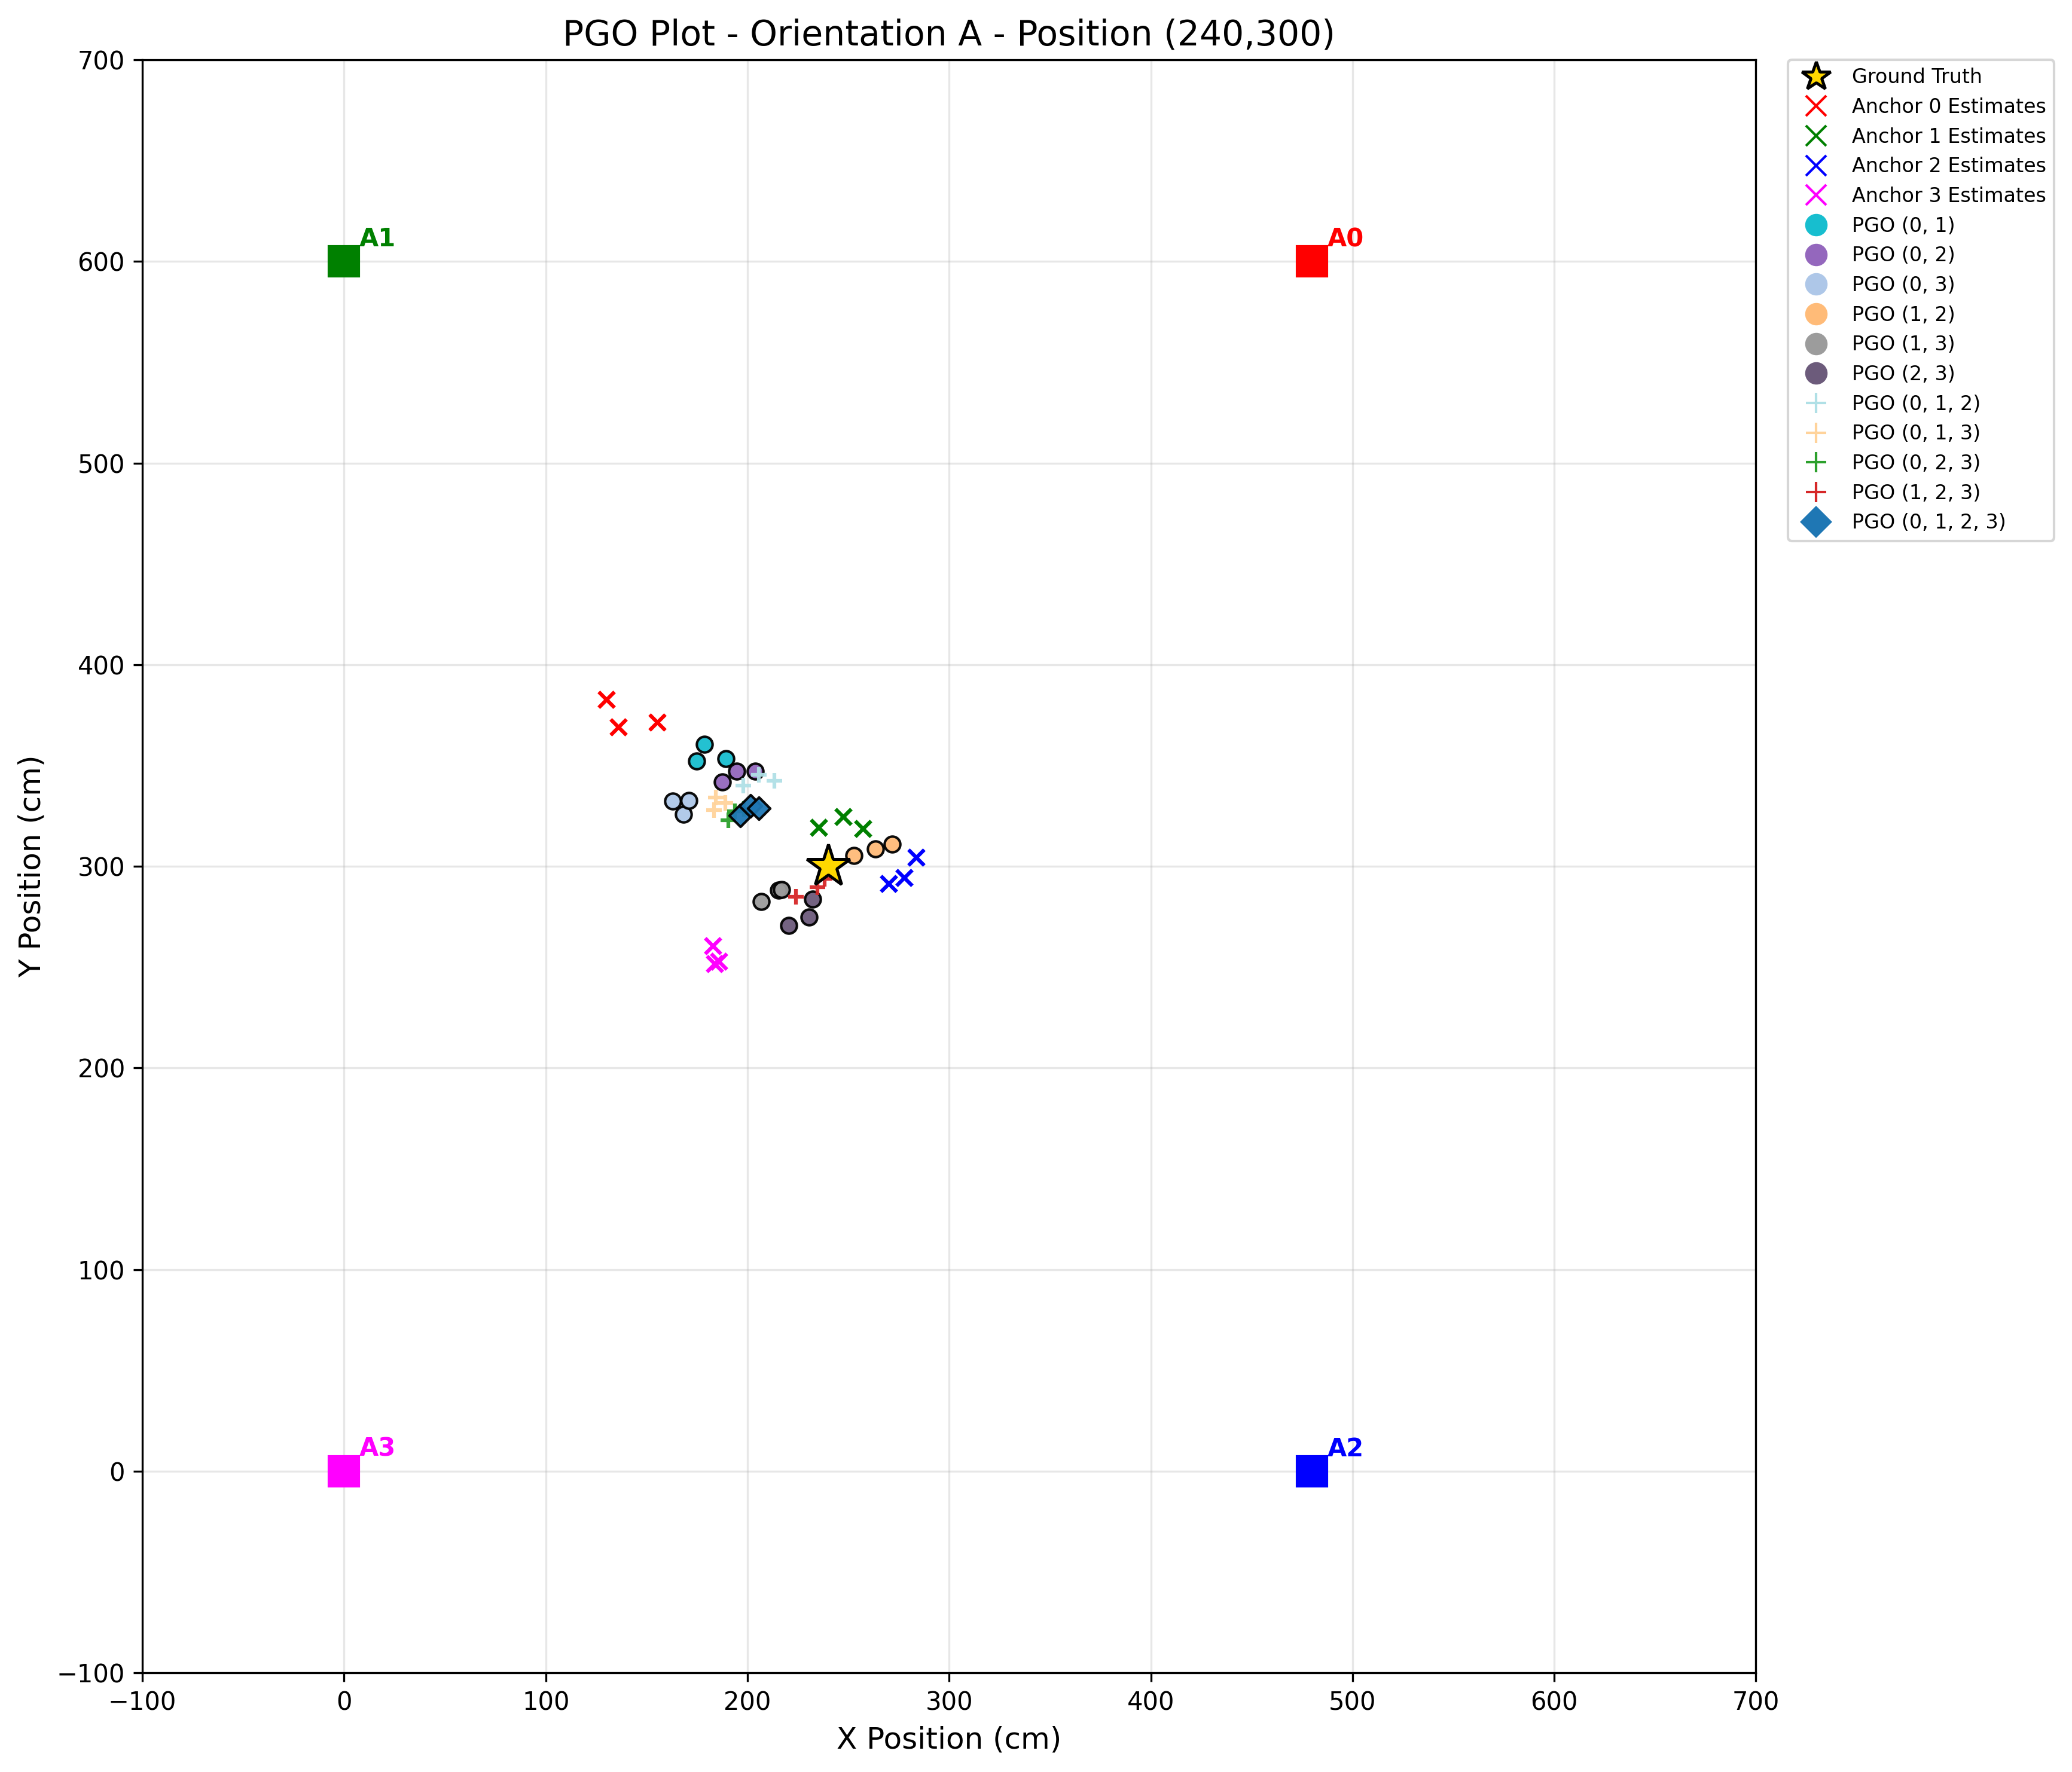

In [82]:
# Render and display God plot for Orientation A, Position (240,300)
from IPython.display import Image, display

target_orientation = 'A'
target_pos = (240.0, 300.0)
subset = [row for row in data if row['orientation'] == target_orientation and (row['ground_truth_x'], row['ground_truth_y']) == target_pos]
if not subset:
    print(f'No data found for orientation {target_orientation} at position {target_pos}')
else:
    print(f'Rendering orientation {target_orientation} position {target_pos} (N={len(subset)})')
    create_god_plot_v5(target_orientation, subset, output_dir)
    img_path = os.path.join(output_dir, f'pgo_plot_v5_orientation_{target_orientation}_pos_{int(target_pos[0])}_{int(target_pos[1])}.png')
    if os.path.exists(img_path):
        print('Displaying:', img_path)
        display(Image(filename=img_path))
    else:
        print('Expected image not found at', img_path)


In [49]:
worst_details['single'][0]

{'pos_estimates': [array([ -6.47337014, -31.00063569]),
  array([-60.85874136,  85.85921043]),
  array([-65.17723828,  87.01977429])],
 'distances': [31.669290077297365, 105.24063101313, 108.72218497905277],
 'avg_distance': 81.87736868982671}

In [50]:
worst_details['multi'][(0, 1)]

{'pgo_results': [array([16.69789694, -7.61097976]),
  array([-22.54570061,  47.1381432 ]),
  array([17.79494571, 27.07948666])],
 'distances': [18.350661432405325, 52.25239860422064, 32.403066068608744],
 'avg_distance': 34.33537536841157}

In [19]:
# call create_god_plot_v5 to create plots and return position_estimates
position_estimates = create_god_plot_v5(data, output_dir)


Processing orientation A:
Found 4 positions: [(0.0, 0.0), (120.0, 180.0), (240.0, 0.0), (240.0, 300.0)]

  Processing position (0.0, 0.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [3] (avg error: 80.6cm)
    2 anchors - worst case: [1, 3] (avg error: 55.1cm)
    3 anchors - worst case: [1, 2, 3] (avg error: 44.5cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 18.0cm)
Saved PGO plot v5 for orientation A, position (0,0) to /Users/shihcheng/Documents/Work/Python/uwb-localization-mesh/Data_collection/Data/28oct/god_plots/PGO_plot_v5_orientation_A_pos_0_0.png

  Processing position (120.0, 180.0):
    Available anchors for this position: [0, 1, 2, 3]
    1 anchor - worst case: [0] (avg error: 107.6cm)
    2 anchors - worst case: [0, 2] (avg error: 59.6cm)
    3 anchors - worst case: [0, 1, 2] (avg error: 40.0cm)
    4 anchors - worst case: [0, 1, 2, 3] (avg error: 25.7cm)
Saved PGO plot v5 for orientation A, position (120,180) to /Users/shihc

In [23]:
print(position_estimates['U'].keys())

dict_keys([(120.0, 180.0), (240.0, 0.0), (240.0, 300.0)])


In [24]:
print(position_estimates['A'][(240.0, 300.0)].keys())

dict_keys(['combinations', 'details'])


In [25]:
print(position_estimates['A'][(240.0, 300.0)]['details']['single'])

{0: {'pos_estimates': [array([135.86934562, 369.08067849]), array([129.97042426, 382.78899139]), array([155.21120351, 371.45141842])], 'distances': [124.9613273037952, 137.6972208639801, 110.88031928033263], 'avg_distance': 124.51295581603597}, 1: {'pos_estimates': [array([235.41438128, 319.41476206]), array([247.4061519 , 324.77950618]), array([257.13829278, 318.65821958])], 'distances': [19.94895698307829, 25.862618053959782, 25.33476340994976], 'avg_distance': 23.71544614899594}, 2: {'pos_estimates': [array([269.84093353, 291.28235014]), array([277.70415033, 294.29376416]), array([283.46337413, 304.52987016])], 'distances': [31.088241075128536, 38.13350337250526, 43.69879419676813], 'avg_distance': 37.64017954813397}, 3: {'pos_estimates': [array([183.69249538, 251.78317009]), array([185.72109646, 252.92232335]), array([182.89111765, 260.69510476])], 'distances': [74.13095010573096, 71.85058808794858, 69.3274781989283], 'avg_distance': 71.76967213086928}}


In [26]:
# create num_py array with 4 columns to hold statistics
all_distances = np.empty((0, 4))  # start with empty array with 4 columns
for orientation in position_estimates:
        # print orientation being processed
        print(f"\nProcessing statistics for orientation {orientation}...")
        # get distances for this orientation
        for pos_key, worst_data in position_estimates[orientation].items():
            # print position being processed
            print(f"  Processing position {pos_key}...")
            worst_details = worst_data.get('details', {})
            # single-anchor distances
            if 'single' in worst_details:
                for anchor_id, sdata in worst_details['single'].items():
                    # print anchor being processed
                    print(f"  Processing single-anchor data for anchor {anchor_id} at position {pos_key}...")
                    distances = sdata.get('distances', [])
                    # append distances to first column (single-anchor)
                    all_distances = np.vstack([all_distances, [distances[0] if distances else np.nan, np.nan, np.nan, np.nan]])
            # multi-anchor distances
            if 'multi' in worst_details:
                for combo, cdata in worst_details['multi'].items():
                    # print combination being processed
                    print(f"  Processing multi-anchor data for combination {combo} at position {pos_key}...")
                    distances = cdata.get('distances', [])
                    # check number of anchors in combo
                    num_anchors = len(combo)
                    # append distances to appropriate column
                    if num_anchors == 2:
                        all_distances = np.vstack([all_distances, [np.nan, distances[0] if distances else np.nan, np.nan, np.nan]])
                    elif num_anchors == 3:
                        all_distances = np.vstack([all_distances, [np.nan, np.nan, distances[0] if distances else np.nan, np.nan]])
                    elif num_anchors == 4:
                        all_distances = np.vstack([all_distances, [np.nan, np.nan, np.nan, distances[0] if distances else np.nan]])




Processing statistics for orientation A...
  Processing position (0.0, 0.0)...
  Processing single-anchor data for anchor 0 at position (0.0, 0.0)...
  Processing single-anchor data for anchor 1 at position (0.0, 0.0)...
  Processing single-anchor data for anchor 2 at position (0.0, 0.0)...
  Processing single-anchor data for anchor 3 at position (0.0, 0.0)...
  Processing multi-anchor data for combination (0, 1) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (0, 2) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (0, 3) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (1, 2) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (1, 3) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (2, 3) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (0, 1, 2) at position (0.0, 0.0)...
  Processing multi-anchor data for combination (0, 1, 3) at position (0.0

In [27]:
print(all_distances.shape)

(217, 4)


In [29]:
# print first 5 rows of all_distances
all_distances[:20]

array([[ 31.66929008,          nan,          nan,          nan],
       [ 26.34446049,          nan,          nan,          nan],
       [ 17.02559016,          nan,          nan,          nan],
       [ 20.35423282,          nan,          nan,          nan],
       [         nan,  18.35066143,          nan,          nan],
       [         nan,  12.14425286,          nan,          nan],
       [         nan,  15.36959539,          nan,          nan],
       [         nan,   9.84364881,          nan,          nan],
       [         nan,  17.77803553,          nan,          nan],
       [         nan,  11.64396902,          nan,          nan],
       [         nan,          nan,  10.50021833,          nan],
       [         nan,          nan,  20.58534401,          nan],
       [         nan,          nan,  11.55451109,          nan],
       [         nan,          nan,  12.2488699 ,          nan],
       [         nan,          nan,          nan,  17.95747159],
       [102.65510186,    

In [34]:
# print the mean of each column, ignoring NaNs
print(np.nanmean(all_distances, axis=0))
# print the max of each column, ignoring NaNs
print(np.nanmax(all_distances, axis=0))
# print the min of each column, ignoring NaNs
print(np.nanmin(all_distances, axis=0))


[68.14713057 53.66629776 47.55619853 44.41480882]
[646.67420554 380.89080886 273.48212061 164.47560377]
[4.75921419 6.77737009 7.86866445 6.26554376]


In [31]:
print(scipy.stats.sem(all_distances, axis=0, nan_policy='omit'))

[11.6451858   6.53148306  6.08242235  9.84116255]


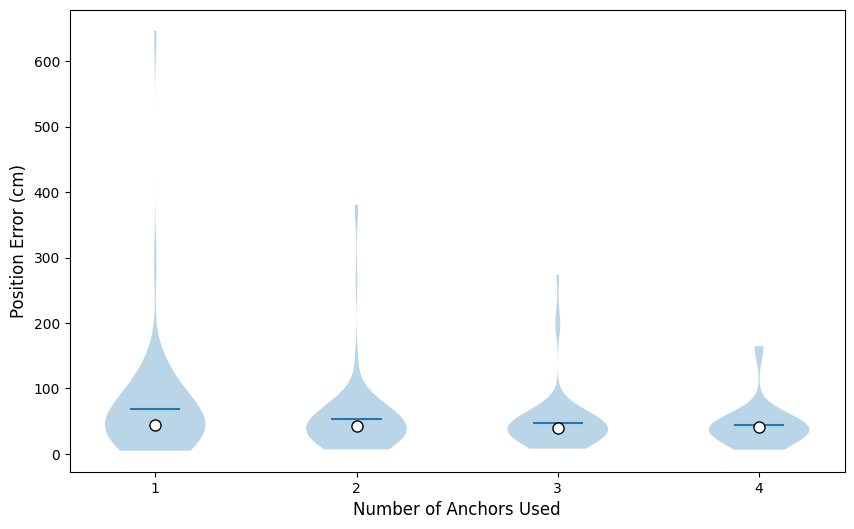

In [46]:
# create violin plots for the four distributions
# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

ax.violinplot([all_distances[:,i][~np.isnan(all_distances[:,i])] for i in range(all_distances.shape[1])],
                  positions=np.arange(1, all_distances.shape[1]+1),
                  showmeans=True, showextrema=False)
# set x-ticks to number of anchors
ax.set_xticks(np.arange(1, all_distances.shape[1]+1))
# add labels and title
ax.set_xlabel('Number of Anchors Used', fontsize=12)
ax.set_ylabel('Position Error (cm)', fontsize=12)

# Mark the median in each violin
medians = [np.median(all_distances[:,i][~np.isnan(all_distances[:,i])]) for i in range(all_distances.shape[1])]
for i, median in enumerate(medians):
    ax.plot(i+1, median, marker='o', color='white', markersize=8, markeredgecolor='black')

Text(0, 0.5, 'Position Error (cm)')

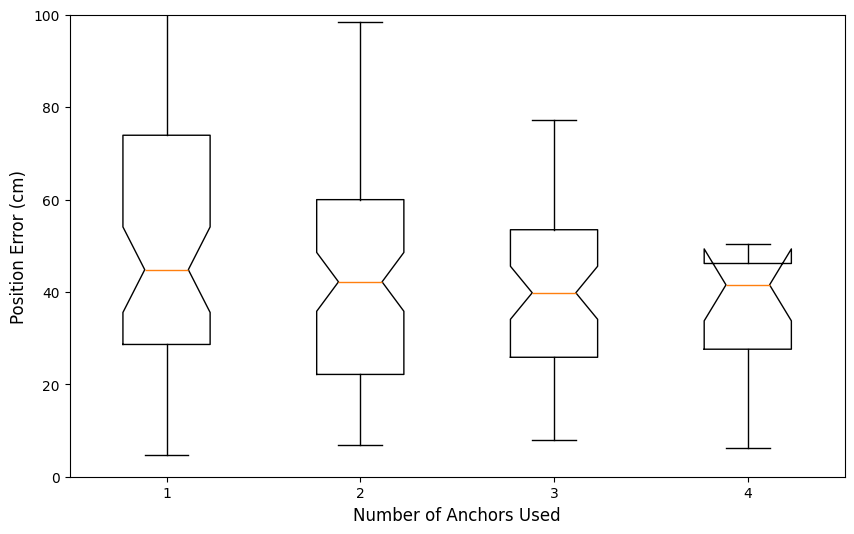

In [41]:
# plot notched box plots
# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([all_distances[:,i][~np.isnan(all_distances[:,i])] for i in range(all_distances.shape[1])],
           positions=np.arange(1, all_distances.shape[1]+1),
           notch=True, showfliers=False)
ax.set_ylim(0, 100)
ax.set_xlabel('Number of Anchors Used', fontsize=12)
ax.set_ylabel('Position Error (cm)', fontsize=12)

In [ ]:
# call stats_for_position_estimates to compute overall statistics and create 
# summary plots
stats_for_position_estimates(position_estimates, output_dir)


In [48]:
# perform statistical tests between the four distributions
from scipy.stats import kruskal, mannwhitneyu

# first check if each of the distributions are normal
from scipy.stats import shapiro
for i in range(all_distances.shape[1]):
    stat, p = shapiro(all_distances[:,i][~np.isnan(all_distances[:,i])])
    print(f"Shapiro-Wilk test for distribution {i+1}: stat={stat:.4f}, p={p:.4f}")

kruskal_result = kruskal(
    all_distances[:,0][~np.isnan(all_distances[:,0])],
    all_distances[:,1][~np.isnan(all_distances[:,1])],
    all_distances[:,2][~np.isnan(all_distances[:,2])],
    all_distances[:,3][~np.isnan(all_distances[:,3])]
)
print("Kruskal-Wallis test result:", kruskal_result)

Shapiro-Wilk test for distribution 1: stat=0.4933, p=0.0000
Shapiro-Wilk test for distribution 2: stat=0.5515, p=0.0000
Shapiro-Wilk test for distribution 3: stat=0.5890, p=0.0000
Shapiro-Wilk test for distribution 4: stat=0.6309, p=0.0001
Kruskal-Wallis test result: KruskalResult(statistic=np.float64(4.177260696791109), pvalue=np.float64(0.24294840414053454))
